<a href="https://colab.research.google.com/github/pablex72/research-camp-time-ser/blob/main/wavelet_sg_liinear_interpolation_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

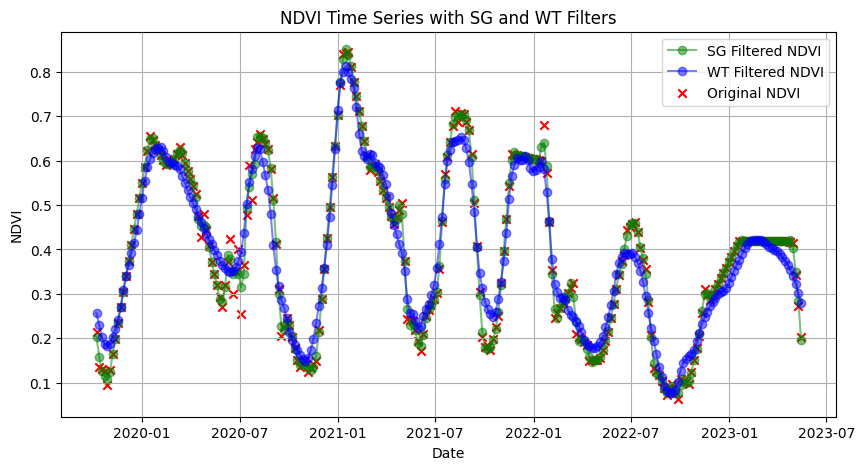

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter
import pywt

# Load the data
df = pd.read_csv('/content/farm4.csv')

# Rename the columns to "Date" and "NDVI"
df = df.rename(columns={'system:time_start': 'Date', 'ndvi': 'NDVI'})

# Convert the "Date" column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Generate a regular date range with the desired interval
start_date = df["Date"].min()
end_date = df["Date"].max()
date_range = pd.date_range(start=start_date, end=end_date, freq="5D")

# Reindex the DataFrame with the new date range
df = df.set_index("Date")
df = df.reindex(date_range)

# Replace missing values with NaN
df["NDVI"] = df["NDVI"].replace(0, np.nan)

# Linearly interpolate missing values
df["NDVI"].interpolate(method='linear', inplace=True)

# Reset the index and rename the columns
df = df.reset_index()
df = df.rename(columns={"index": "Date"})

# Remove rows with missing values
df_trend = df.dropna()

# Apply Savitzky–Golay (SG) filter
window_size = 5
poly_order = 2
df_trend["SG_Filtered"] = savgol_filter(df_trend["NDVI"], window_size, poly_order)

# Apply Wavelet Transform (WT) filter
def wavelet_smooth(data, wavelet="db4", level=1):
    coeffs = pywt.wavedec(data, wavelet, mode="per")
    coeffs[1:] = (pywt.threshold(c, value=0.1, mode="soft") for c in coeffs[1:])
    reconstructed_data = pywt.waverec(coeffs, wavelet, mode="per")
    return reconstructed_data

df_trend["WT_Filtered"] = wavelet_smooth(df_trend["NDVI"])

############################################################################################
# Export the result of the Wavelet Transform (WT) filter to a CSV file
df_wavelet_filtered = df_trend[["Date", "WT_Filtered"]].copy()
df_wavelet_filtered.columns = ["Date", "NDVI"]

# Save to CSV
df_wavelet_filtered.to_csv('/content/wavelet_filtered_ndvi.csv', index=False)
###################################################################################################

# Plot the original and filtered NDVI time series
plt.figure(figsize=(10, 5))
plt.plot(df_trend["Date"], df_trend["SG_Filtered"], label="SG Filtered NDVI", marker="o",alpha=0.5, c='green')
plt.plot(df_trend["Date"], df_trend["WT_Filtered"], label="WT Filtered NDVI", marker="o",alpha=0.5, c='blue')
plt.scatter(df_trend["Date"], df_trend["NDVI"], label="Original NDVI", marker="x", c='red')

plt.title("NDVI Time Series with SG and WT Filters")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.legend()
plt.grid(True)
plt.show()
